In [1]:
import torch
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device, torch.__version__)

cuda:0 1.9.0+cu102


In [2]:
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install torch-geometric
import torch_geometric

Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html


# **1) Attention Layer**

In [3]:
from torch_scatter import scatter_mean, scatter_add

# Defining the Attention Mechanism as a Separate Class of itself
class AttentionLayer(torch.nn.Module):
    def __init__(self, d = 16, activation=2, a = 0.1):
        """
        :param: d: Output Dimension of the Node Embeddings
        :param: activation: The Activation Function to be used for the Attention Layer
        :param: a: Slope of the -ve part if the activation is Leaky ReLU
        """
        super(AttentionLayer, self).__init__()
        self.d = d # Output dimension of the Convolution Vector for each Node
        self.activation = activation 
        self.a = a # Slope of the negative part in Leaky-ReLU
        
        self.params()
        self.initialize()
        
    def params(self):
        self.W_att = torch.nn.Parameter(torch.Tensor(self.d, self.d))

    def initialize(self):
        """
        Initialization depends upon the activation function used.
        If ReLU/ Leaky ReLU : He (Kaiming) Initialization
        If tanh/ sigmoid : Xavier Initialization
        0-ReLU, 1-Leaky ReLU, 2-tanh, 3-sigmoid
        """
        non_lin = {0:"relu", 1:"leaky_relu", 2:"tanh", 3:"sigmoid"}
        
        if (self.activation==1) or (self.activation==0):
            torch.nn.init.kaiming_normal_(self.W_att, a=self.a, nonlinearity=non_lin[self.activation])
        elif (self.activation==2) or (self.activation==3):
            torch.nn.init.xavier_normal_(self.W_att)
        else:
            raise ValueError("Activation can only take values 0,1,2,3!")

    def forward(self, node_embeddings, batch, size = None):
        """ 
        :param: node_embeddings :(N_B x D) Tensor containing Node Embeddings
        :param: batch : Tensor containing the Graph to which Each Node in the Batch belongs
        :param: size : Check Documentation https://pytorch-scatter.readthedocs.io/en/1.3.0/functions/mean.html
        :return: global_graph_embedding for each graph in the batch
        """
        size = batch[-1].item()+1 if size is None else size # Gives Batch Size = B
        
        global_context = scatter_mean(node_embeddings,index = batch, dim=0, dim_size = size) # (N_B,D) -> (B,D) (mean)
        global_context = torch.matmul(global_context, self.W_att) # (B,D) x (D,D) -> (B,D)
        
        # Applying the Non-Linearity over W_att*mean(U_i), the default is tanh
        if self.activation==2:
            global_context = torch.tanh(global_context)
        elif self.activation==1:
            leaky_relu = torch.nn.LeakyReLU()
            global_context = leaky_relu(global_context)
        elif self.activation==0:
            global_context = global_context.relu()
        elif self.activation==3:
            global_context = torch.sigmoid(global_context)
        
        # Getting the attention value for each Node for a Given Graph
        e = torch.sum(node_embeddings*global_context[batch], dim=1) # (N_B,D) * (N_B,D) -> (N_B,1) (due to sum along dimension D) 
        attn_weights = e.sigmoid() # (N_B, 1)
        
        # Calculating the Global Graph Embedding
        global_graph_embedding = scatter_add(node_embeddings*attn_weights.unsqueeze(-1),
                                             index=batch, dim=0, dim_size=size) # (N_B,D) x (N_B,1) -> (B,D)
        
        return global_graph_embedding

# **2) Neural Tensor Network Layer**

In [4]:
# Defining the Neural Tensor Network Layer as a Separate Class of Itself
class NTNLayer(torch.nn.Module):
    def __init__(self, d=16, k=16, activation=0, a = 0.1):
        """
        :param: d: Input Dimension of the NTN - i.e Dimension of the Graph/ Node Embeddings
        :param: k: Output Dimension of the NTN - No. of Similarity Scores to output
        :param: activation: Activation Function to be used for the NTN - Default = ReLU
        :param: a: Slope of the negative part for a Leaky ReLU activation
        """
        super(NTNLayer, self).__init__()
        self.d = d # Input Dimension of the NTN
        self.k = k # Output dimension of the NTN
        self.a = a # Slope in case of Leaky ReLU initialization 
        self.activation = activation
        self.params()
        self.initialize()
    
    def params(self):
        self.W = torch.nn.Parameter(torch.Tensor(self.d,self.d,self.k))
        self.V = torch.nn.Parameter(torch.Tensor(self.k, 2*self.d))
        self.b = torch.nn.Parameter(torch.Tensor(self.k,1))

    def initialize(self): 
        """
        Initialization depends upon the activation function used.
        If ReLU/ Leaky ReLU : He Initialization
        If tanh/ sigmoid : Xavier Initialization
        0-ReLU, 1-Leaky ReLU, 2-tanh, 3-sigmoid
        """
        non_lin = {0:"relu", 1:"leaky_relu", 2:"tanh", 3:"sigmoid"}
        if (self.activation==1) or (self.activation==0):
            torch.nn.init.kaiming_normal_(self.W, a=self.a, nonlinearity=non_lin[self.activation])
            torch.nn.init.kaiming_normal_(self.V, a=self.a, nonlinearity=non_lin[self.activation])
            torch.nn.init.kaiming_normal_(self.b, a=self.a, nonlinearity=non_lin[self.activation])
            
        elif (self.activation==2) or (self.activation==3):
            torch.nn.init.xavier_normal_(self.W)
            torch.nn.init.xavier_normal_(self.V)
            torch.nn.init.xavier_normal_(self.b)
        
        else:
            raise ValueError("Activation can only take values 0,1,2,3!")
        
    def forward(self, h1, h2):
        """Returns 'K' Rough Similarity Scores between the Pair of Graphs
        The Neural Tensor Network (NTN) outputs 'K' similarity scores where 'K' is a hyperparameter
        :param: h1 : Graph Embedding of Graph 1 - (B,D)
        :param: h2 : Graph Embedding of Graph 2 - (B,D)
        """
        B,_ = h1.shape
        scores = torch.mm(h1, self.W.view(self.d, -1)) # (B,D) x (D, K+D) -> (B, K+D)
        scores = scores.view(B,self.d,self.k) # (B,K+D) -> (B,D,K)
        scores = (scores*h2.unsqueeze(-1)).sum(dim=1) # (B,D,K) * (B,D,1) -> (B,K)
        
        concatenated_rep = torch.cat((h1, h2), dim=1) # (B,2D)
        scores = scores + torch.mm(concatenated_rep, self.V.t()) # (B,2D) x (2D,K) -> (B,K)
        scores = scores + self.b.t() # (B,K) + (1,K) = (B,K)
        
        if self.activation==0:
            scores = scores.relu()
            return scores
        elif self.activation==1:
            leaky_relu = torch.nn.LeakyReLU()
            scores = leaky_relu(scores)
            return scores
        elif self.activation==2:
            scores = torch.tanh(scores)
            return scores
        elif self.activation==3:
            scores = torch.sigmoid(scores)
            return scores
        else:
            raise ValueError("Activation can only take values 0,1,2,3!")

# **3) SimGNN - Putting it Together**

In [5]:
# Writing the Entire SimGNN Model
from torch_geometric.utils import to_dense_batch, to_dense_adj
from torch_geometric.nn import GCNConv
from torch.nn import Linear

class SimGNN(torch.nn.Module):
    def __init__(self, num_node_features, hist=True, ntn_layer=True, d=16, k=16, bins = 16):
        super(SimGNN, self).__init__()
        self.setupHyperParams(hist, ntn_layer, d, k, bins, num_node_features)
        self.setupLayers()
        
    def setupHyperParams(self, hist, ntn_layer, d, k, bins, num_node_features):
        self.num_node_features = num_node_features
        # Dimension of the Node/ Graph Embeddding
        self.d = d
        # Output Dimension of the NTN
        self.k = k
        # Do we want to include the NTN Layer in the pipeline
        self.ntn_layer = ntn_layer
        # Do we want to use the histogram strategy
        self.hist = hist
        # No. of Bins to be used for the Histogram 
        self.bins = bins
    
    def fcnnInputDim(self):
        """Calculate The Input Dimension of the FCNN Layer"""
        if self.hist and self.ntn_layer:
            return self.bins+self.k
        elif self.hist:
            return self.bins + 1
        elif self.ntn_layer:
            return self.k
        else : 
            # Instead of NTN ,we would just be using a simple dot product
            # between the Graph Embeddings to Compute Similarities
            return 1
    
    def setupLayers(self):
        fcnn_input_dim = self.fcnnInputDim()
        
        # Layers of SimGNN
        # GCN Layers
        self.conv1 = GCNConv(self.num_node_features,64)
        self.conv2 = GCNConv(64,32)
        self.conv3 = GCNConv(32,self.d)
        
        # Attention Layer and Neural Tensor Network Layer 
        self.attention_layer = AttentionLayer(self.d)
        self.NTN = NTNLayer(self.d, self.k)
        
        # Fully Connected Layer
        self.linear_1 = torch.nn.Linear(fcnn_input_dim,16)
        self.linear_2 = torch.nn.Linear(16,8)
        self.linear_3 = torch.nn.Linear(8,4)
        self.linear_4 = torch.nn.Linear(4,1)
    
    def GCN(self, x, edge_index):
        """
        Implementing the Graph Convolutional Network
        :param x : One Hot Encoded Feature Representation of the Nodes
        :param edge_index : Tensor Representation of Edges to calculate Adjacency Matrix
        :U : (N_B x D) matrix of Node Embeddings
        :N_B : Total No. of Nodes in the Batch (irrespective of parent graph) 
        :D : dimensions of the Node Embeddings (decided by us)
        I haven't implemented Dropout/ BatchNorm but can also try to do that
        """
        U = self.conv1(x, edge_index)
        U = U.relu()
        U = self.conv2(U, edge_index)
        U = U.relu()
        U = self.conv3(U, edge_index)
        return U

    def kernel(self, graph_embedding_1, graph_embedding_2):
        pass

    def rbf_kernel_sim(self, graph_embedding_1, graph_embedding_2):
        """
        :param: graph_embedding_1 : (B,D) dimensional graph embedding
        :param: graph_embedding_2 : (B,D) dimensional graph embedding
        :return: rbf_sim : RBF Kernel Similarity the two graph embeddings
        """
        distance = graph_embedding_1-graph_embedding_2
        distance = torch.sum(distance*distance, dim = 1)
        return torch.exp(-distance).view(-1,1)
    
    def histogram(self, U1, U2, batch1, batch2):
        """ B = Batch Size
        To calculate the Histogram Representation of the Pairwise Interaction Tensor
        :param: U1 : (N_B1 x D) matrix which encodes the node embeddings of Graph 1
        :param: U2 : (N_B2 x D) matrix which encodes the node embeddings of Graph 2
        :param: batch1 : Logs the Parent graph of the Nodes
        :param: batch2 : Logs the Parent Graph of the Nodes
        :return: norm_hist_scores : (B x self.bins) Normalized histogram for each batch
        """
        # Convert U1 and U2 into Dense Matrices
        U1, mask1 = to_dense_batch(U1, batch1) # (B, N_max1, D); (B, N_max1)
        U2, mask2 = to_dense_batch(U2, batch2) # (B, N_max2, D); (B, N_max2)
        B, N_max1, _ = U1.size()
        B, N_max2, _ = U2.size()
        
        # Max Number of Nodes for Each Graph Pair in the Batch
        max_total_nodes = torch.max(mask1.sum(dim=1), mask2.sum(dim=1)).view(-1) # (B,1)
         
        # Calculating Interaction Scores for the entire batch
        interaction_scores = torch.matmul(U1, U2.permute(0,2,1)).detach() # (B, N_max1, N_max2)
        interaction_scores = torch.sigmoid(interaction_scores)

        # Getting the Histogram for each Pair in the batch
        hist_score_list = []
        for i in range(B):
            interaction_matrix = interaction_scores[:,:max_total_nodes[i], :max_total_nodes[i]]
            hist_score = torch.histc(interaction_matrix, bins = self.bins).view(-1) # (self.bins,)
            hist_score = hist_score/hist_score.sum() # Normalizing the Histogram
            hist_score_list.append(hist_score)

        return torch.stack(hist_score_list).view(B, self.bins) # (B, self.bins)
    
    def FCNN(self, x):
        """:param: x: Rough Similarity Scores of 'B' Graph Pairs where B is Batch Size"""
        ged_sim = self.linear_1(x)
        ged_sim = ged_sim.relu()
        
        ged_sim = self.linear_2(ged_sim)
        ged_sim = ged_sim.relu()
        
        ged_sim = self.linear_3(ged_sim)
        ged_sim = ged_sim.relu()
        ged_sim = self.linear_4(ged_sim)
        
        return ged_sim
    
    def forward(self, data):
        """
         Forward pass with graphs.
         :param data: A Batch Containing a Pair of Graphs.
         :return score: Similarity score.
         """
        edge_index_1 = data.edge_index_1
        edge_index_2 = data.edge_index_2
        x1, x2 = data.x1, data.x2
        x1_batch , x2_batch = data.x1_batch, data.x2_batch

        # Passed through GCN
        node_embeddings_1 = self.GCN(x1, edge_index_1)
        node_embeddings_2 = self.GCN(x2, edge_index_2)

        # Passed through Attention Layer to get Graph Embedding
        graph_embedding_1 = self.attention_layer(node_embeddings_1, x1_batch)
        graph_embedding_2 = self.attention_layer(node_embeddings_2, x2_batch)
        
        # Passed through Neural Tensor Network if allowed otherwise just take a simple Inner Product
        if self.ntn_layer:
            scores = self.NTN(graph_embedding_1, graph_embedding_2)
        else:
            scores = self.rbf_kernel_sim(graph_embedding_1, graph_embedding_2)
            
        # Computed Histogram from the Node Embeddings (Strategy 2)
        if self.hist:
            hist = self.histogram(node_embeddings_1, node_embeddings_2, x1_batch, x2_batch)
            scores = torch.cat((scores, hist), dim=1) # (B, K+self.bins)

        # Pass through the Fully Connected Neural Network Layer to get Graph Edit Distance Similarity
        ged_pred = self.FCNN(scores)
        
        return ged_pred.view(-1)

# **4) Loading Data & Feature Engineering**

In [40]:
name = "LINUX"
from torch_geometric.datasets import GEDDataset
train_graphs = GEDDataset(root="./data/train", train = True, name=name)
test_graphs = GEDDataset(root="./data/test", train = False, name=name)

print(f"Number of Graphs in Train Set : {len(train_graphs)}")
print(f"Number of Graphs in Test Set : {len(test_graphs)}")

Number of Graphs in Train Set : 800
Number of Graphs in Test Set : 200


In [7]:
i = 1
print(train_graphs[i])
print(test_graphs[i])

Data(edge_index=[2, 8], i=[1])
Data(edge_index=[2, 14], i=[1])


## **a) Creating a Feature Matrix for the Graphs**

In [41]:
from torch_geometric.transforms import OneHotDegree
from torch_geometric.utils import degree

# If the dataset does not have a feature matrix, we create one!
# Only the AIDS700nef Dataset has an inbuilt feature matrix
# We create a One Hot Encoded Degree Feature Matrix
if train_graphs[0].x is None:
            max_degree = 0
            for graph in train_graphs + test_graphs:
                # If this graph has edges then do
                if graph.edge_index.size(1) > 0:
                    max_degree = max(max_degree, int(degree(graph.edge_index[0]).max().item()))
            
            # Create the feature matrix for the Dataset
            one_hot_degree = OneHotDegree(max_degree, cat=False)
            train_graphs.transform = one_hot_degree
            test_graphs.transform = one_hot_degree

num_node_features = train_graphs.num_features
num_edge_features = train_graphs.num_edge_features
print(num_node_features, num_edge_features)

8 0


## **b) Making Pairs of Graphs**

In [42]:
class makeGraphPairs(torch_geometric.data.Data):
    """ Documentation
    :param: edge_index_1 : Edge Index of the First Graph
    :param: edge_index_2 : Edge Index of the Second Graph in the pair
    :param: x_1 : Feature Matrix of the First Graph in the Pair
    :param: x_2 : Feature Matrix of the Second Graph in the Pair
       
    :returns: torch_geometric.data.Data object which comprises two graphs
    """
    def __init__(self, edge_index_1, x1, edge_index_2, x2, ged, norm_ged, graph_sim):
        super(makeGraphPairs, self).__init__()
        self.edge_index_1 = edge_index_1
        self.x1 = x1
        self.edge_index_2 = edge_index_2
        self.x2 = x2
        self.ged = ged
        self.norm_ged = norm_ged
        self.graph_sim = graph_sim

    def __inc__(self, key, value):
        if key == "edge_index_1":
            return self.x1.size(0)
        elif key == "edge_index_2":
            return self.x2.size(0)
        else:
            return super().__inc__(key, value)

### **i. For Training**

In [43]:
"""TRAINING SET PAIR"""
# Data List to pass into the Data Loader to get Batches
train_graph_pair_list = []

# Making the Pairs of Graphs
for graph1_num, graph1 in enumerate(train_graphs):
    # To avoid double counting
    for graph2 in train_graphs[graph1_num:]:
        # Initializing Data
        edge_index_1 = graph1.edge_index
        x1 = graph1.x
        edge_index_2 = graph2.edge_index
        x2 = graph2.x
        ged = train_graphs.ged[graph1.i, graph2.i]
        norm_ged = train_graphs.norm_ged[graph1.i, graph2.i]
        graph_sim = torch.exp(-norm_ged)
        
        # Making Graph Pair
        graph_pair = makeGraphPairs(edge_index_1=edge_index_1, x1=x1, 
                                    edge_index_2=edge_index_2, x2=x2,
                                    ged=ged ,norm_ged=norm_ged, graph_sim = graph_sim)
        
        # Saving all the Graph Pairs to the List for Batching and Data Loading
        train_graph_pair_list.append(graph_pair)

### **ii. For Testing**

In [44]:
"""TEST SET PAIR"""
# Data List to pass into the Data Loader to get batches
test_graph_pair_list = []

# Making the Pairs of Graphs
for graph1 in test_graphs:
    for graph2 in train_graphs:
        # Initializing Data
        edge_index_1 = graph1.edge_index
        x1 = graph1.x
        edge_index_2 = graph2.edge_index
        x2 = graph2.x
        ged = train_graphs.ged[graph1.i, graph2.i]
        norm_ged = train_graphs.norm_ged[graph1.i, graph2.i]
        graph_sim = torch.exp(-norm_ged)
        
        # Making Graph Pair
        graph_pair = makeGraphPairs(edge_index_1=edge_index_1, x1=x1, 
                                    edge_index_2=edge_index_2, x2=x2,
                                    ged=ged ,norm_ged=norm_ged, graph_sim = graph_sim)
        
        # Saving all the Graph Pairs to the List for Batching and Data Loading
        test_graph_pair_list.append(graph_pair)

In [29]:
print("Number of Training Graph Pairs = {}".format(len(train_graph_pair_list)))
print("Number of Training Test Pairs = {}".format(len(test_graph_pair_list)))

Number of Training Graph Pairs = 157080
Number of Training Test Pairs = 78400


In [30]:
test_graph_pair_list[1]

makeGraphPairs(edge_index_1=[2, 20], edge_index_2=[2, 16], ged=[1], graph_sim=[1], norm_ged=[1], x1=[10, 29], x2=[9, 29])

# **5) Training Begins**

In [45]:
batch_size = 128
from torch_geometric.data import DataLoader
train_loader = DataLoader(train_graph_pair_list, batch_size = batch_size, follow_batch = ["x1", "x2"], shuffle = True)
test_loader = DataLoader(test_graph_pair_list, batch_size = batch_size, follow_batch = ["x1", "x2"], shuffle = True)

In [15]:
batch = next(iter(train_loader))
#batch = batch.to(device)
print(batch)
print(batch.edge_index_1.get_device())

Batch(edge_index_1=[2, 1708], edge_index_2=[2, 1756], ged=[128], graph_sim=[128], norm_ged=[128], x1=[946, 8], x1_batch=[946], x2=[956, 8], x2_batch=[956])
-1


In [47]:
num_iters = len(train_loader)
print(num_iters)

2504


In [17]:
def evaluate(dataloader, model):
    loss = 0
    num_ex = 0
    model.eval()
    for data in dataloader:
        data = data.to(device)
        y_pred = model(data)
        l = loss_criterion(y_pred, data.graph_sim)
        loss = (loss*num_ex + l*len(data.ged))/(num_ex+len(data.ged))
        num_ex += len(data.ged)
    model.train()
    return loss.item()

def evaluate_test(dataloader, model):
    test_loss = []
    model.eval()
    for data in dataloader:
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        data = data.to(device)
        y_pred = model(data)
        test_loss.append(loss_criterion(y_pred, data.graph_sim))
    model.train()
    return torch.mean(torch.stack(test_loss)).item()

In [48]:
model = SimGNN(num_node_features, ntn_layer = False).to(device)
loss_criterion = torch.nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr = 0.001)
epochs = 10000//num_iter+1
min_loss = 1000

import time
import copy
train_loss_arr = []
test_loss_arr = []
tik = time.time()

for epoch in tqdm(range(epochs), desc="Epochs"):
    for i, data in enumerate(train_loader):
        opt.zero_grad()
        data = data.to(device)
        y_pred = model(data)
        loss = loss_criterion(y_pred.view(-1), data.graph_sim)
        loss.backward()
        opt.step()
        
        # Model Checkpointing
        if min_loss>loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(model.state_dict())
            #print('Min loss %0.2f' % min_loss)
        
        # Printing Loss Values
        if i%200 == 0:
            print(f"Iteration: {i}/{num_iters}, Train Loss: {loss}")
        
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        train_loss_arr.append(loss.item())
    
    # Printing Epoch Summary
    print("Epoch: {}/{}, Train MSE: {}, Test MSE: {}".format(epoch+1, epochs, train_loss_arr[-1],
                                                          evaluate_test(test_loader, model)))

tok = time.time()





Epochs:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration: 0/2504, Train Loss: 0.7502843141555786
Iteration: 200/2504, Train Loss: 0.021033501252532005
Iteration: 400/2504, Train Loss: 0.0056993719190359116
Iteration: 600/2504, Train Loss: 0.0035994937643408775
Iteration: 800/2504, Train Loss: 0.0028360383585095406
Iteration: 1000/2504, Train Loss: 0.0028485930524766445
Iteration: 1200/2504, Train Loss: 0.002874080091714859
Iteration: 1400/2504, Train Loss: 0.002712225541472435
Iteration: 1600/2504, Train Loss: 0.002897716360166669
Iteration: 1800/2504, Train Loss: 0.0023131719790399075
Iteration: 2000/2504, Train Loss: 0.002750932704657316
Iteration: 2200/2504, Train Loss: 0.0021342968102544546
Iteration: 2400/2504, Train Loss: 0.0028644856065511703






Epochs:  25%|██▌       | 1/4 [02:59<08:59, 179.87s/it]

Epoch: 1/4, Train MSE: 0.0036061073187738657, Test MSE: 0.0024018194526433945
Iteration: 0/2504, Train Loss: 0.0030047420877963305
Iteration: 200/2504, Train Loss: 0.0024389917962253094
Iteration: 400/2504, Train Loss: 0.0019758231937885284
Iteration: 600/2504, Train Loss: 0.0023972210474312305
Iteration: 800/2504, Train Loss: 0.0023838933557271957
Iteration: 1000/2504, Train Loss: 0.0025604479014873505
Iteration: 1200/2504, Train Loss: 0.0016578438226133585
Iteration: 1400/2504, Train Loss: 0.002563946880400181
Iteration: 1600/2504, Train Loss: 0.0016224486753344536
Iteration: 1800/2504, Train Loss: 0.001962751615792513
Iteration: 2000/2504, Train Loss: 0.0018017145339399576
Iteration: 2200/2504, Train Loss: 0.00195359718054533
Iteration: 2400/2504, Train Loss: 0.001974451122805476






Epochs:  50%|█████     | 2/4 [05:59<05:59, 179.76s/it]

Epoch: 2/4, Train MSE: 0.0029230061918497086, Test MSE: 0.0019535261671990156
Iteration: 0/2504, Train Loss: 0.0021883463487029076
Iteration: 200/2504, Train Loss: 0.0018010175554081798
Iteration: 400/2504, Train Loss: 0.0017277435399591923
Iteration: 600/2504, Train Loss: 0.0015086641069501638
Iteration: 800/2504, Train Loss: 0.002586269285529852
Iteration: 1000/2504, Train Loss: 0.0026873848401010036
Iteration: 1200/2504, Train Loss: 0.0018747685244306922
Iteration: 1400/2504, Train Loss: 0.0014993059448897839
Iteration: 1600/2504, Train Loss: 0.001346586854197085
Iteration: 1800/2504, Train Loss: 0.0013177655637264252
Iteration: 2000/2504, Train Loss: 0.0013839115854352713
Iteration: 2200/2504, Train Loss: 0.0016591805033385754
Iteration: 2400/2504, Train Loss: 0.0017407929990440607






Epochs:  75%|███████▌  | 3/4 [08:57<02:59, 179.13s/it]

Epoch: 3/4, Train MSE: 0.001089904340915382, Test MSE: 0.001594069297425449
Iteration: 0/2504, Train Loss: 0.0013874333817511797
Iteration: 200/2504, Train Loss: 0.001351002138108015
Iteration: 400/2504, Train Loss: 0.0015436707763001323
Iteration: 600/2504, Train Loss: 0.0018152616685256362
Iteration: 800/2504, Train Loss: 0.0016619896050542593
Iteration: 1000/2504, Train Loss: 0.001385468989610672
Iteration: 1200/2504, Train Loss: 0.0012871171347796917
Iteration: 1400/2504, Train Loss: 0.0014706326182931662
Iteration: 1600/2504, Train Loss: 0.0020777322351932526
Iteration: 1800/2504, Train Loss: 0.0014106656890362501
Iteration: 2000/2504, Train Loss: 0.001365435542538762
Iteration: 2200/2504, Train Loss: 0.001399458386003971
Iteration: 2400/2504, Train Loss: 0.0014049190795049071






Epochs: 100%|██████████| 4/4 [11:52<00:00, 178.19s/it]

Epoch: 4/4, Train MSE: 0.0015241203363984823, Test MSE: 0.0014165552565827966


Time taken for Training = 712.7607362270355s


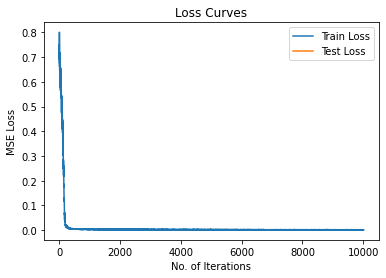

In [49]:
print("========================================================")
print(f"Time taken for Training = {(tok-tik)}s")
plt.plot(train_loss_arr[:], label = "Train Loss")
plt.plot(test_loss_arr, label = "Test Loss")
plt.legend()
plt.title("Loss Curves")
plt.xlabel("No. of Iterations")
plt.ylabel("MSE Loss")
plt.show()

In [50]:
model.load_state_dict(best_model)

<All keys matched successfully>

In [51]:
evaluate_test(test_loader, model)

0.0014558141119778156

In [ ]:
#torch.save(model,f'simgnn-{name}.pth')